This notebook uses several different models to predict popularity using likes/views as popularity calculation. Additionally, this notebook uses topics as a predictor.

In [2]:
import numpy as np
import pandas as pd
import ast
from collections import OrderedDict
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

For this regression model, we are going to use the sentiment analysis dataset, which includes the TextBlob and VADER scores from the sentiment analysis algorithm.

In [3]:
df = pd.read_csv("../data/data_sentiment_analysis.csv")
#df = df[0:20]
# print(len(df))
df = df.dropna()
# print(len(df))
df.describe()

,Unnamed: 0.1,Unnamed: 0,_id,duration,likes,views,tb_score,vd_score
count,4983.000000,4983.000000,4983.000000,4983.000000,4.983000e+03,4.983000e+03,4983.000000,4983.000000
mean,2732.942003,2732.942003,24648.154525,686.436885,7.051936e+04,2.370903e+06,0.108438,0.741949
std,1648.784090,1648.784090,29866.800844,385.181603,1.134161e+05,3.833013e+06,0.062795,0.627445
min,0.000000,0.000000,1.000000,60.000000,1.260000e+02,4.209000e+03,-0.259643,-0.999900
25%,1290.500000,1290.500000,1515.500000,339.000000,2.700000e+04,9.297965e+05,0.070541,0.980050
50%,2654.000000,2654.000000,2854.000000,683.000000,4.500000e+04,1.517960e+06,0.108392,0.997700
75%,4176.500000,4176.500000,48651.500000,930.000000,6.900000e+04,2.323995e+06,0.146548,0.999400
max,5630.000000,5630.000000,95714.000000,4154.000000,2.200000e+06,7.338914e+07,0.594444,1.000000


In [4]:
# create popularity column by dividing likes and views
df['likes_log'] = np.log(df['likes'])
df['popularity'] = (df['likes']/df['views']) * 100

# Let's view the dataset again
df.head()
df['topics_list'] = df['topics_list'].apply(ast.literal_eval)
# print(type(df['topics_list'][0]))
#print(type(df['topics'][0]))

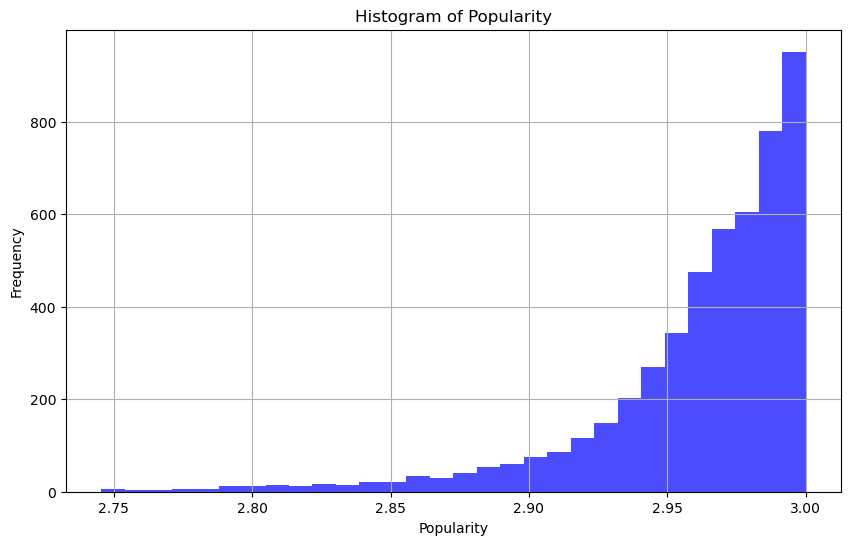

In [5]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['popularity'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

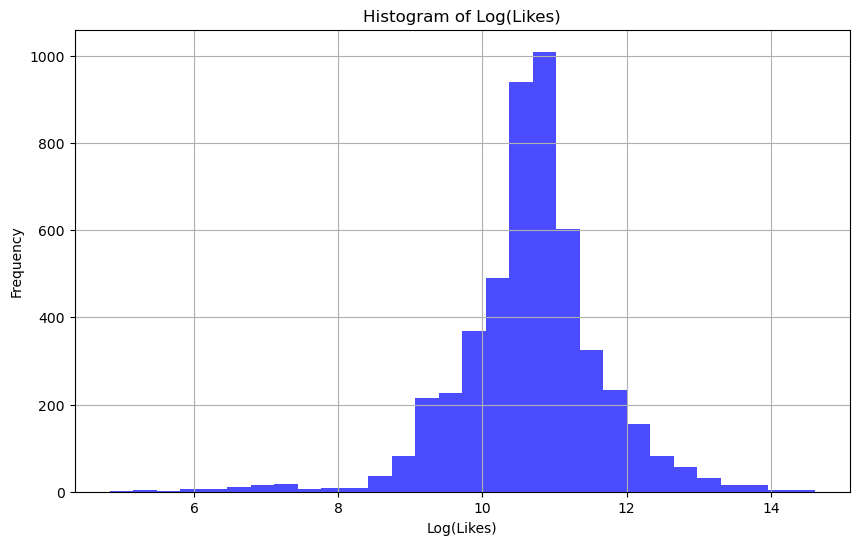

In [6]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['likes_log'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Log(Likes)')
plt.xlabel('Log(Likes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Count instances of each topic from the topics list column, and only keep topics that appear >100 times in the dataset.

In [8]:
from collections import Counter

topics = [thing for inner_list in df['topics_list'].tolist() for thing in inner_list]
count_topics = Counter(topics)
count_dict = dict(count_topics)

# print(count_dict)

# topics with less than 100 instances
under_100 = {k:v for (k,v) in count_dict.items() if v < 100}

Print list of all the topics.

In [11]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(df['topics_list'])
print(mlb.classes_)

['3D printing' 'AI' 'AIDS' 'Africa' "Alzheimer's" 'Antarctica'
 'Anthropocene' 'Asia' 'Audacious Project' 'Autism spectrum disorder'
 'Best of the Web' 'Big Bang' 'Brazil' 'Buddhism' 'CRISPR' 'Christianity'
 'Countdown' 'DNA' 'Egypt' 'Europe' 'Hinduism' 'Humanities' 'Internet'
 'Islam' 'Judaism' 'LGBTQIA+' 'Life' 'Mars' 'Middle East' 'Mission Blue'
 'Moon' 'NASA' 'NFTs' 'PTSD' 'Planets' 'Slavery' 'South America'
 'String theory' 'Sun' 'Surgery' 'TED Books' 'TED Connects' 'TED Fellows'
 'TED Membership' 'TED Prize' 'TED Residency' 'TED en Español' 'TED-Ed'
 'TEDMED' 'TEDx' 'Transgender' 'UX design' 'United States' 'Vaccines'
 'activism' 'addiction' 'aging' 'agriculture' 'algorithm' 'aliens'
 'ancient world' 'animals' 'animation' 'anthropology' 'archaeology'
 'architecture' 'art' 'asteroid' 'astrobiology' 'astronomy' 'atheism'
 'augmented reality' 'bacteria' 'beauty' 'bees' 'behavioral economics'
 'biodiversity' 'bioethics' 'biology' 'biomimicry' 'bionics' 'biosphere'
 'biotech' 'birds' 

In [13]:
# there are 351 different topics
print(len(mlb.classes_))

351


In [14]:
# one hot encode the topics in the topics list
topics_encoded = pd.DataFrame(mlb.fit_transform(df['topics_list']), columns=mlb.classes_, index=df.index)
df_encoded = pd.concat([df, topics_encoded], axis=1).drop('topics_list', axis=1)
df_encoded

,Unnamed: 0.1,Unnamed: 0,_id,duration,likes,speakers,subtitle_languages,summary,topics,title,...,water,weather,wind energy,women,women in business,work,work-life balance,worklife,writing,youth
0,0,0,21,992,17000,"[{'name': 'Mena Trott', 'occupation': 'Blogger...","[{'name': 'English', 'code': 'en'}, {'name': '...","The founding mother of the blog revolution, Mo...","[{'id': '4', 'name': 'culture'}, {'id': '13', ...",Meet the founder of the blog revolution,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,957,110000,"[{'name': 'Al Gore', 'occupation': 'Climate ad...","[{'name': 'Greek', 'code': 'el'}, {'name': 'Gu...",With the same humor and humanity he exuded in ...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Averting the climate crisis,...,0,0,0,0,0,0,0,0,0,0
2,2,2,7,1266,60000,"[{'name': 'David Pogue', 'occupation': 'Techno...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",New York Times columnist David Pogue takes aim...,"[{'id': '10', 'name': 'technology'}, {'id': '3...",Simplicity sells,...,0,0,0,0,0,0,0,0,0,0
3,3,3,47,1126,80000,"[{'name': 'David Deutsch', 'occupation': 'Phys...","[{'name': 'Greek', 'code': 'el'}, {'name': 'En...",Legendary scientist David Deutsch puts theoret...,"[{'id': '3', 'name': 'climate change'}, {'id':...",Chemical scum that dream of distant quasars,...,0,0,0,0,0,0,0,0,0,0
4,4,4,55,1524,14000,"[{'name': 'Jehane Noujaim', 'occupation': 'Fil...","[{'name': 'English', 'code': 'en'}, {'name': '...",Jehane Noujaim unveils her 2006 TED Prize wish...,"[{'id': '4', 'name': 'culture'}, {'id': '6', '...",My wish: A global day of film,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626,5626,5626,95714,278,5800,"[{'name': 'Lyla Latif', 'occupation': 'Educato...","[{'name': 'English', 'code': 'en'}, {'name': '...","In 2020, Mali produced over 71 tons of gold— a...","[{'id': '18', 'name': 'business'}, {'id': '19'...",The true cost of gold,...,0,0,0,0,0,0,0,0,0,0
5627,5627,5627,95710,940,10000,"[{'name': 'Trish Millines Dziko', 'occupation'...","[{'name': 'English', 'code': 'en'}, {'name': '...","Forget home economics and standardized tests, ...","[{'id': '52', 'name': 'education'}, {'id': '53...",How schools can nurture every student's genius,...,0,0,0,0,0,0,0,0,0,1
5628,5628,5628,95451,1048,12000,"[{'name': 'David Wengrow', 'occupation': 'Arch...","[{'name': 'English', 'code': 'en'}, {'name': '...",What if the commonly accepted narratives about...,"[{'id': '4', 'name': 'culture'}, {'id': '81', ...",A new understanding of human history and the r...,...,0,0,0,0,0,0,0,0,0,0
5629,5629,5629,95708,651,7200,"[{'name': 'Dan Widmaier', 'occupation': 'Bioma...","[{'name': 'English', 'code': 'en'}]",Your closet is likely full of all kinds of mat...,"[{'id': '5', 'name': 'environment'}, {'id': '8...",The future of fashion -- made from mushrooms,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# get rid of the topics with too few instances

df_encoded = df_encoded.drop(columns=under_100.keys())

In [17]:
# view columns
df_encoded.columns.tolist()

['Unnamed: 0.1',
 'Unnamed: 0',
 '_id',
 'duration',
 'likes',
 'speakers',
 'subtitle_languages',
 'summary',
 'topics',
 'title',
 'transcript',
 'views',
 'recorded_date',
 'published_date',
 'speakers_list',
 'sl_list',
 'processed_transcript',
 'tb_score',
 'vd_score',
 'likes_log',
 'popularity',
 'Africa',
 'Countdown',
 'Internet',
 'TED Fellows',
 'TED-Ed',
 'TEDx',
 'United States',
 'activism',
 'animals',
 'animation',
 'architecture',
 'art',
 'biology',
 'brain',
 'business',
 'cities',
 'climate change',
 'collaboration',
 'communication',
 'community',
 'computers',
 'creativity',
 'culture',
 'data',
 'decision-making',
 'democracy',
 'design',
 'disease',
 'economics',
 'education',
 'energy',
 'engineering',
 'entertainment',
 'entrepreneur',
 'environment',
 'equality',
 'evolution',
 'exploration',
 'family',
 'food',
 'future',
 'gender',
 'global issues',
 'government',
 'happiness',
 'health',
 'health care',
 'history',
 'human body',
 'humanity',
 'humor',
 'i

In [18]:
# view length of variables
len(df_encoded.columns.tolist())

119

In [19]:
# eliminate columns from dataset that we do not need for model
X = df_encoded.drop(['Unnamed: 0.1', 'Unnamed: 0', '_id', 'likes', 'published_date', 'recorded_date', 'speakers', 'subtitle_languages', 'summary', 'title', 'topics', 'transcript','views', 'speakers_list','sl_list','processed_transcript', 'popularity', 'likes_log'], axis=1)
# assign the y variable to be popularity
y = df_encoded['likes_log']

In [20]:
# split data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X.head()

,duration,tb_score,vd_score,Africa,Countdown,Internet,TED Fellows,TED-Ed,TEDx,United States,...,storytelling,sustainability,technology,universe,violence,visualizations,war,women,work,writing
0,992,0.133855,0.9996,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,957,0.131762,0.9997,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,1266,0.155493,0.9999,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1126,0.066814,0.9990,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,1524,0.127882,0.9995,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression

In [23]:
from sklearn import linear_model

In [24]:
# fit model using scaled training data
reg = linear_model.LinearRegression().fit(X_train_scaled, y_train)
reg.score(X_train_scaled, y_train)

0.14024677553022324

In [25]:
# predict y value and calculate mse
y_pred_linear = reg.predict(X_test_scaled)
mse_linear = np.mean((y_pred_linear - y_test) ** 2)
mse_linear

0.8875797307140668

In [26]:
print(mean_squared_error(y_test, y_pred_linear))
print(r2_score(y_test, y_pred_linear))

0.8875797307140668
0.09192294015401081


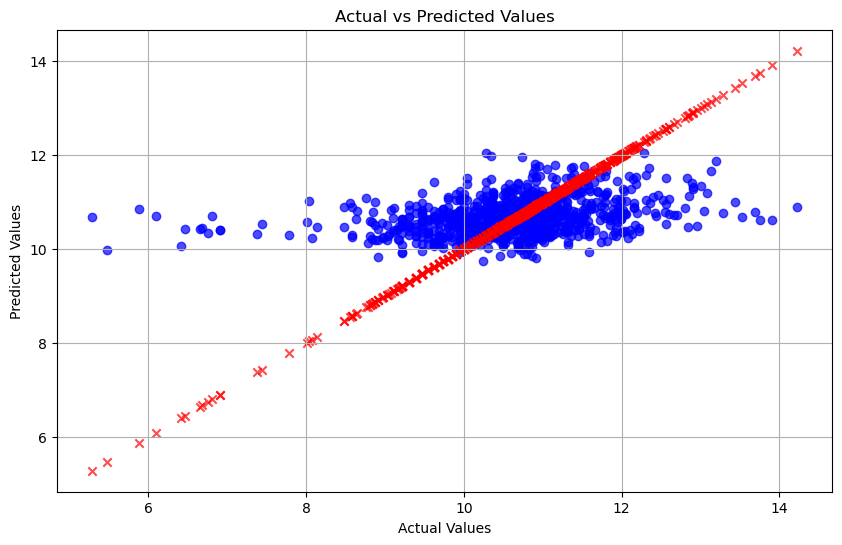

In [27]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_linear  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Lasso Regression

In [29]:
reg = linear_model.Lasso(alpha=1)
reg.fit(X_train_scaled, y_train)

Lasso(alpha=1)

In [30]:
# predict popularity using lasso regression
y_pred_lasso = reg.predict(X_test_scaled)
mse_lasso = np.mean((y_pred_lasso - y_test) ** 2)
mse_lasso

0.980582355210467

In [31]:
print(mean_squared_error(y_test, y_pred_lasso))
print(r2_score(y_test, y_pred_lasso))

0.980582355210467
-0.0032274411449266793


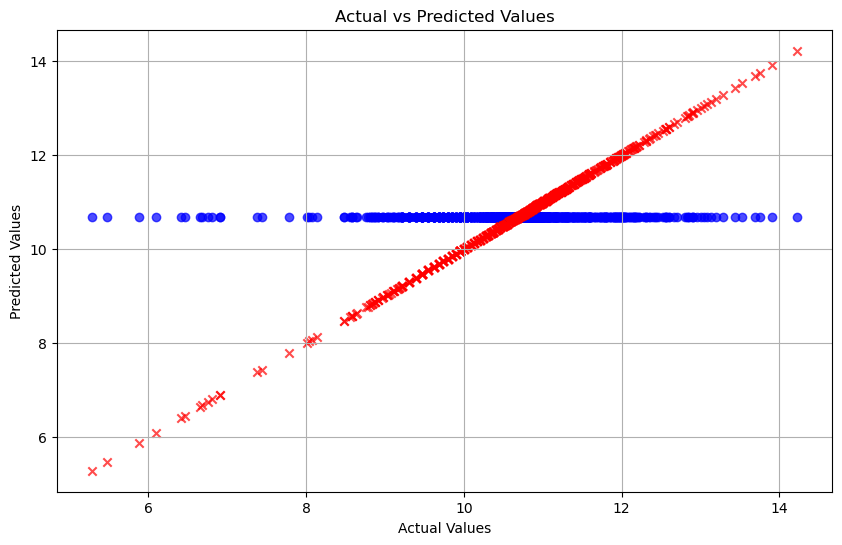

In [32]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_lasso  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Support Vector Regression

In [33]:
svr_linear = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_poly = SVR(kernel='poly', degree=3, C=1.0, epsilon=0.1)
svr_sigmoid = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

In [34]:
svr_linear.fit(X_train_scaled, y_train)
svr_rbf.fit(X_train_scaled, y_train)
svr_poly.fit(X_train_scaled, y_train)
svr_sigmoid.fit(X_train_scaled, y_train)

SVR(kernel='sigmoid')

In [35]:
y_pred_svr_linear = svr_linear.predict(X_test_scaled)
y_pred_rbf = svr_rbf.predict(X_test_scaled)
y_pred_poly = svr_poly.predict(X_test_scaled)
y_pred_sigmoid = svr_sigmoid.predict(X_test_scaled)

In [36]:
mse_linear = np.mean((y_pred_svr_linear - y_test) ** 2)
mse_linear

0.8833033341065389

In [37]:
print(r2_score(y_test, y_pred_svr_linear))
print(r2_score(y_test, y_pred_rbf))
print(r2_score(y_test, y_pred_poly))
print(r2_score(y_test, y_pred_sigmoid))

0.0962980937584933
0.12765529900071382
0.05297063322136342
-3.7613152720799565


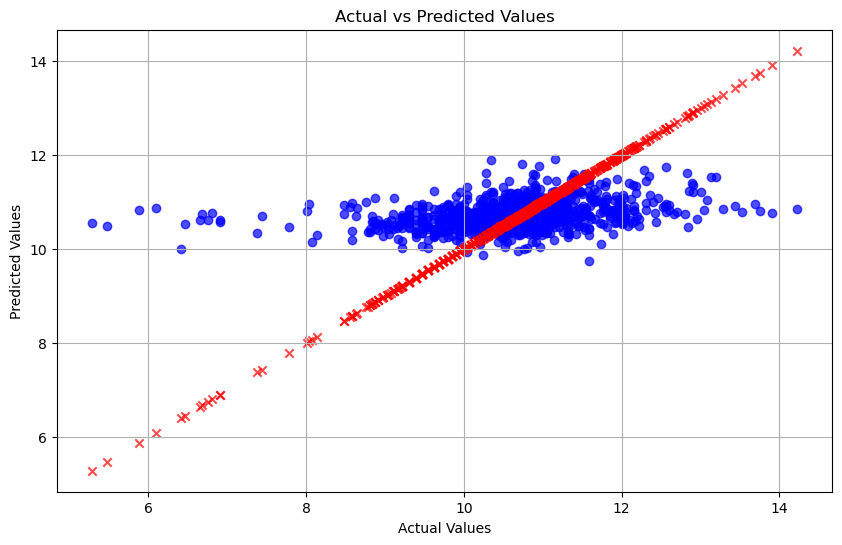

In [38]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_svr_linear  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [39]:
mse_rbf = np.mean((y_pred_rbf - y_test) ** 2)
mse_rbf

0.8526539310816942

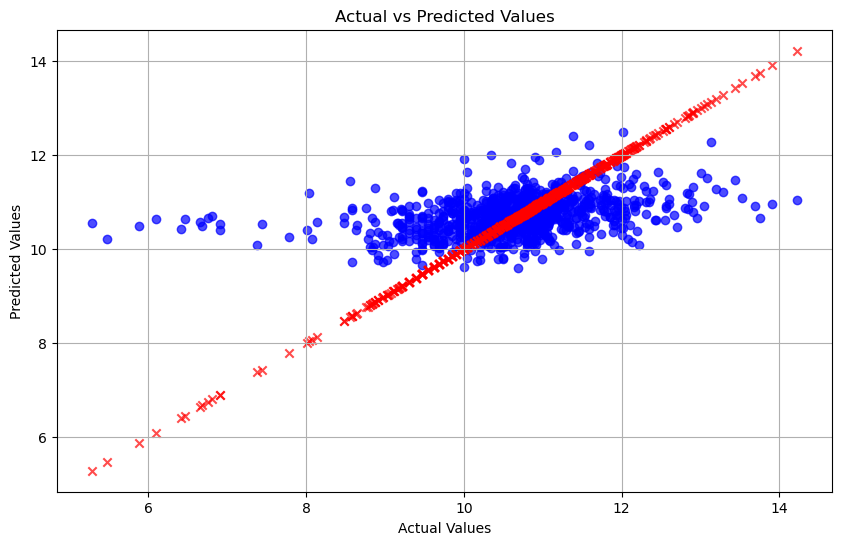

In [40]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_rbf  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [41]:
mse_poly = np.mean((y_pred_poly - y_test) ** 2)
mse_poly

0.9256527970062981

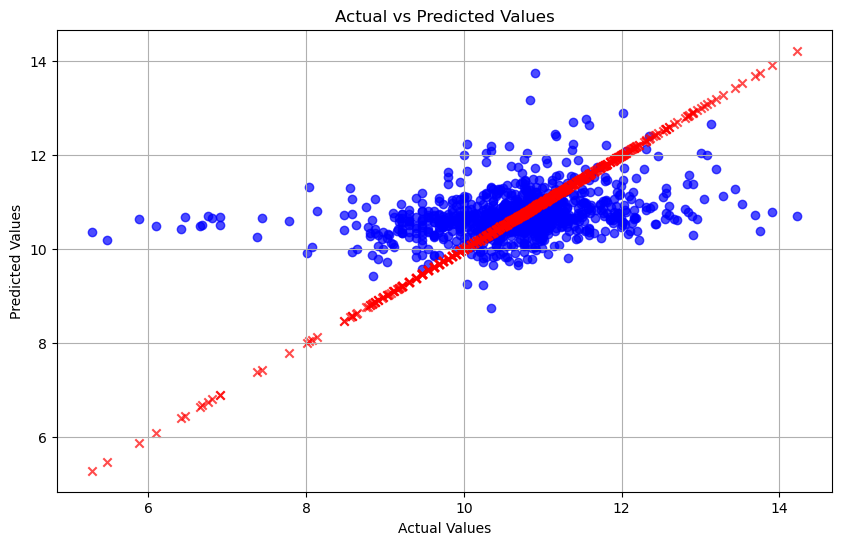

In [42]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_poly  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [43]:
mse_sigmoid = np.mean((y_pred_sigmoid - y_test) ** 2)
mse_sigmoid

4.653841743072161

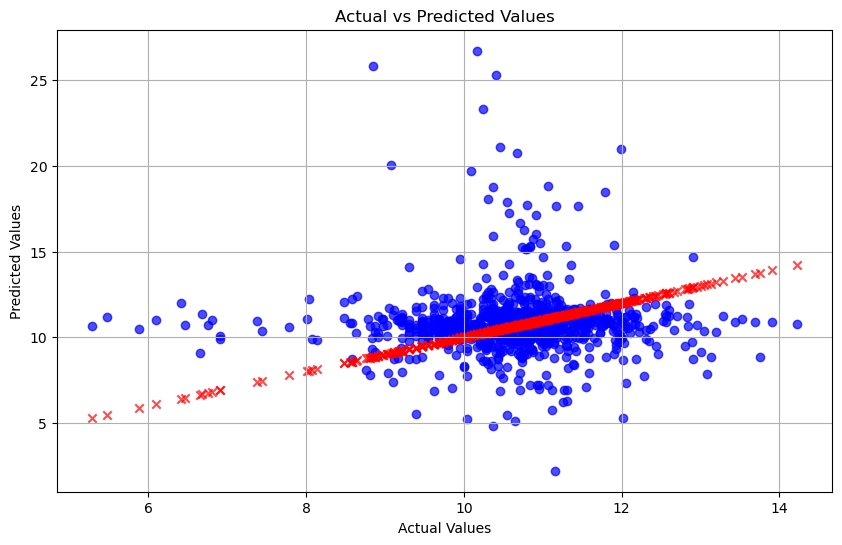

In [44]:
import matplotlib.pyplot as plt

# Actual values from the DataFrame
actual_values = y_test # Replace 'actual_values' with the actual column name

# Predicted values from the DataFrame
predicted_values = y_pred_sigmoid  # Replace 'predicted_values' with the actual column name

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Predicted Values', marker='o')
plt.scatter(actual_values, actual_values, color='red', alpha=0.7, label='Actual Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [46]:
print("Linear R2", r2_score(y_test, y_pred_linear))
print("Lasso R2", r2_score(y_test, y_pred_lasso))
print("SVR Linear R2", r2_score(y_test, y_pred_svr_linear))
print("SVR RBF R2", r2_score(y_test, y_pred_rbf))
print("SVR Poly R2", r2_score(y_test, y_pred_poly))
print("SVR Sigmoid R2", r2_score(y_test, y_pred_sigmoid))

Linear R2 0.09192294015401081
Lasso R2 -0.0032274411449266793
SVR Linear R2 0.0962980937584933
SVR RBF R2 0.12765529900071382
SVR Poly R2 0.05297063322136342
SVR Sigmoid R2 -3.7613152720799565
